In [1]:
import jieba
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from transformers import BertTokenizer, BertModel

In [6]:
directory = "../dat/甜點"
all_comments = []

# 遍歷目錄中的所有文件
file_names = os.listdir(directory)
for file_name in file_names:
    file_path = os.path.join(directory, file_name)
    if not os.path.isfile(file_path): continue
    if not file_path.endswith('.json'): continue
    if os.path.getsize(file_path) == 0: continue
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            comments = data.get('comments', [])
            all_comments.extend(comments)
    except: 
        print("something wrong in "+file_path)

print(len(all_comments))

26087


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese')

In [6]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return torch.mean(last_hidden_states, 1).squeeze().detach().numpy()

In [7]:
df = pd.DataFrame(all_comments)
df = df.drop(columns='other').dropna(subset=['comment'])

In [8]:
# 初始化空列表來存儲嵌入
embeddings = []

# 使用tqdm顯示進度條
for comment in tqdm(df['comment'], desc="Calculating BERT embeddings"):
    # 對評論進行分詞，先進行類型檢查和處理
    embedding = get_bert_embedding(comment)
    embeddings.append(embedding)

# 將嵌入添加到數據框
df['bert_embedding'] = embeddings

Calculating BERT embeddings: 100%|████████| 21627/21627 [14:18<00:00, 25.20it/s]


In [9]:
X = np.vstack(df['bert_embedding'].values)

Using ***Principal Component Analysis (PCA)*** method

In [19]:
reduced_X = PCA(n_components=2).fit_transform(X)

/var/folders/ql/_w19z0t509qf1m5dl7qqzjmc0000gn/T/ipykernel_49132/1120710779.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_X[:, 0], reduced_X[:, 1], cmap='jet', s=0.1)


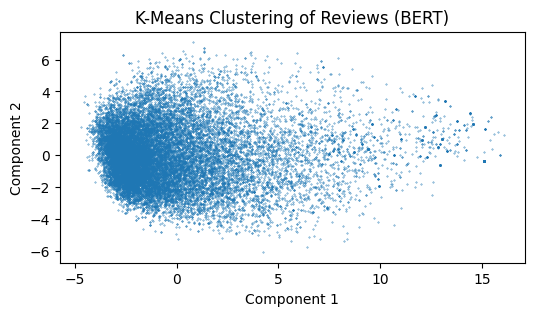

In [23]:
# 繪製結果
fig = plt.figure(figsize=(6, 3))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], cmap='jet', s=0.1)
plt.title('K-Means Clustering of Reviews (BERT)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Using ***Elbow Method*** by observing the relation between **Sum of Squared Errors** and **Cluster number**

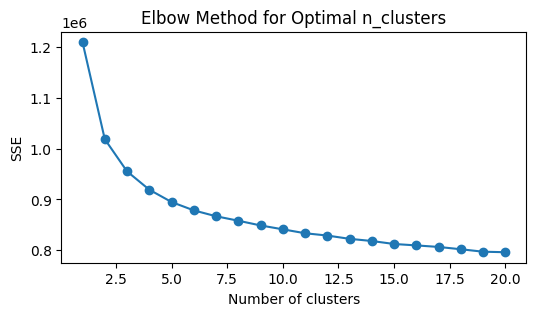

In [25]:
# 使用肘部法則確定最佳的聚類數量
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# 繪製肘部法則圖
fig = plt.figure(figsize=(6, 3))
plt.plot(range(1, 21), sse, marker='o')
plt.title('Elbow Method for Optimal n_clusters')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

Using K-Means to classify the comment

In [30]:
# 使用 K-means 進行聚類
kmeans = KMeans(n_clusters=4, random_state=23)
df['cluster'] = kmeans.fit_predict(X)

In [31]:
sil_score = silhouette_score(X, df['cluster'])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.09305884689092636


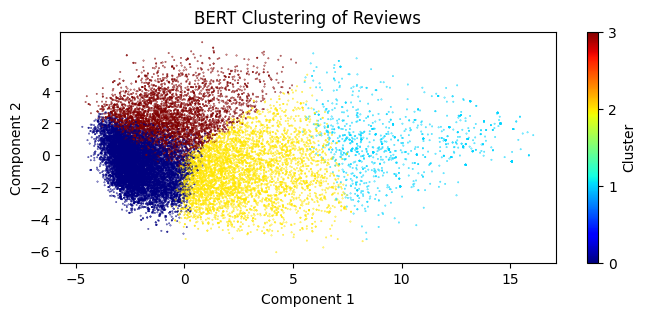

In [36]:
# 繪製結果
fig = plt.figure(figsize=(8, 3))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df['cluster'], cmap='jet', s=0.1)
plt.title('BERT Clustering of Reviews')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster', ticks=np.arange(df['cluster'].min(), df['cluster'].max() + 1))
plt.show()

In [107]:
df[df['cluster'] == 0]

,author,comment,star,bert_embedding,cluster,anomaly-0.05
0,TZU-HSUAN CHUANG,這間 有錢也買不到\n營不營業 在不在這裡擺\n全部看老闆心情啊啊啊啊啊！\n妳無論怎麼問 ...,5,"[0.7907704, 0.023078535, -0.14742005, 0.424830...",0,1
1,chelsea chang,1.照片右邊的是此家店的，左邊是在東市場裡買的。2.價格都是$20。3.可看出，右邊的較透明...,3,"[0.8116879, -0.17959112, -0.09079031, 0.342416...",0,1
2,sho micky,綠豆露雖然有點甜但好吃\n還有菜燕 現在很難吃到傳統點心,5,"[0.3545232, 0.0881715, -0.3533192, 0.2761139, ...",0,1
3,Arlene,好吃，而且不會很甜，就是小時候記憶中的味道！早起的鳥兒有蟲吃，賣完就收攤了，太晚去會撲空喔！...,5,"[0.6608559, 0.11536657, -0.23615138, 0.3409125...",0,1
4,Yuehua Wun,古早味零負擔小點心，冰冰涼涼又清甜，銅板價,5,"[1.3575766, -0.09089799, -0.68242705, 0.071478...",0,1
...,...,...,...,...,...,...
26072,Dabo Ann Wang,夾餡甜圈超級好吃💓 一定要回訪の雞蛋糕！老闆娘親切笑容有夠Q可愛～～,5,"[0.4359396, -0.13295089, -0.08643657, 0.296447...",0,1
26073,謝芷芸,從沒有實體店面時就有吃過！夾餡甜甜圈還是很好吃！（但甜甜圈要先預定而且只有六日一有）,5,"[0.5504194, 0.022974672, -0.36029813, 0.431238...",0,1
26075,陳郁婕,超推薦菇菇口味，原本以為會不搭，結果超好吃的\n其他口味有很棒喔!\n闆娘人很好，值得推薦的!!!,5,"[1.0694582, -0.08331302, -0.50844276, 0.444796...",0,1
26084,楊映彤,老闆人超好🥹本來是路過要買豆花，結果想吃的芋圓跟粉粿都沒有了🤣臨走前就被老闆塞了三個車輪餅說...,5,"[0.5346007, 0.04079232, -0.39634466, 0.4622274...",0,1


In [108]:
df[df['cluster'] == 1]

,author,comment,star,bert_embedding,cluster,anomaly-0.05
424,Hanna Lin,舒服的小天地,5,"[0.32577178, -0.66701627, 0.12032307, 0.049793...",1,-1
425,陳昱宏,剛好甜,5,"[-0.21821089, 0.6031839, -0.76160157, 0.365178...",1,-1
605,Tony,甜點好吃,5,"[0.08686171, 0.48735598, -1.165585, 0.29892156...",1,1
648,Lovi Chen,核 桃 好 多,5,"[0.2152714, -0.19484432, -0.58333695, 0.512266...",1,1
654,Lester790416,巴斯克好吃,5,"[-0.71486026, -0.05168392, -1.3288628, 0.35432...",1,1
...,...,...,...,...,...,...
26051,陳明豐,非常好吃,5,"[-0.49180555, 0.43161437, -0.6568874, 0.016972...",1,1
26052,簡湘玲,好吃,5,"[-0.46534622, 0.3548276, -1.3464688, 0.4188956...",1,-1
26053,于麗娟,好吃😋,5,"[-0.49815893, 0.4154939, -1.202735, 0.19725771...",1,-1
26055,Jaime bien,蠻順口的,5,"[0.50571084, 0.53387624, -0.24936604, 0.515955...",1,1


In [109]:
df[df['cluster'] == 2]

,author,comment,star,bert_embedding,cluster,anomaly-0.05
6,Simon Shih,好吃的菜燕（洋菜凍）、綠豆露、杏仁露、綠豆粉粿。都是古早味小吃甜點。,5,"[0.797213, -0.05290244, -0.4321325, 0.3947856,...",2,1
7,カクテル,綠豆露好好吃\n每天早上9點來，賣完就沒了,5,"[0.46473223, -0.07865059, -0.3805427, 0.636548...",2,1
9,ᄋᄏ,有夠讚 小時候回憶,5,"[0.10787636, 0.3713377, 0.2484924, 0.38750345,...",2,-1
50,劉秋惠,特別的冰店使用桂圓製糖水\n料好實在喔,5,"[0.8016275, 0.07317603, -0.3852412, 0.65518963...",2,1
74,Vito Huang,便宜大碗，料多實在,5,"[0.27556956, 0.12751834, -1.2389795, 0.599489,...",2,1
...,...,...,...,...,...,...
26074,林淳,有餡的雞蛋糕與眾不同，香Q濃⋯好吃\n老闆可愛笑容可掬,5,"[0.76491314, 0.21726407, -0.47885227, 0.268987...",2,1
26076,阮盈軒,超～～～好吃😋\n最喜歡黑糖麻糬燒口味！,5,"[0.37280875, 0.13140117, -0.5097524, 0.814936,...",2,1
26077,Lunn Wang,雞蛋糕很美味 下午茶好選擇,5,"[0.41074124, 0.38873369, -0.5808248, 0.3942759...",2,1
26079,林明宏,東西好吃😋 最愛花生什麼思,5,"[0.20469591, 0.045717917, -0.68972546, 0.19226...",2,1


In [110]:
df[df['cluster'] == 3]

,author,comment,star,bert_embedding,cluster,anomaly-0.05
34,胡廷倫,蜜地瓜和冰都超級好吃 而且價格也不貴\n內用的話只有旁邊的木桌椅 位子不多,5,"[0.47110242, -0.09935813, -0.4778668, 0.571784...",3,1
49,JOSH TSENG,老屋🏚️吃冰\n份量很夠\n店家還很貼心能夠調整甜度\n態度也非常親切😍,5,"[0.74427474, 0.05878522, -0.020177163, 0.32041...",3,1
63,濠濠,蜜地瓜很普通\n冰品部份也很普\n員工看起來蠻多的\n但出餐很慢 .. 超級慢 ..,1,"[0.8520848, -0.084068134, -0.5451445, 0.539605...",3,1
73,貓咪簡,古早味👍東西好吃\n人員也很熱情❤️‍🔥,5,"[0.7738014, 0.17019112, -0.31462482, 0.3129341...",3,1
98,Edward,用料還不錯，不會太貴。內用區在戶外，是木頭的桌椅。不過停車沒那麼好停。,5,"[0.41200307, 0.08179377, -0.092106804, 0.62253...",3,1
...,...,...,...,...,...,...
25950,Andrew Glossa,喝杯咖啡和吃豆子的好地方。老闆和員工都很友善，烘焙機的味道很香。,5,"[0.6736533, -0.019636277, -0.20711072, 0.25794...",3,1
25951,Yi-Chen Chen,咖啡不錯，但甜點不太令人印象深刻。,3,"[0.6045334, 0.42817923, -0.3870663, 0.25193253...",3,1
25955,Barb Rebentisch,舒適，還有很棒的咖啡,5,"[0.24928765, 0.46636567, 0.15910941, 0.1578137...",3,1
26045,湘羚許,環境舒適好停車，闆娘人很客氣哦！,5,"[0.72952664, -0.19272584, -0.2791007, 0.678403...",3,1


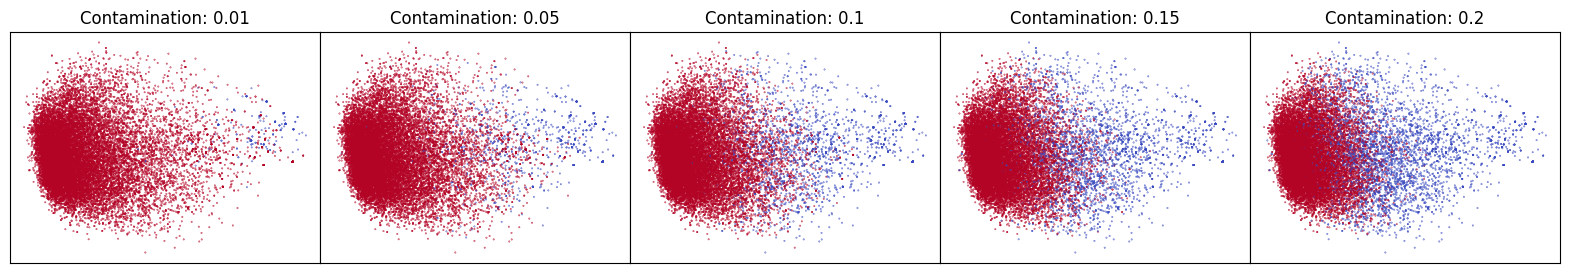

In [52]:
contamination_values = [0.01, 0.05, 0.1, 0.15, 0.2]
anomaly_results = {}

for contamination in contamination_values:
    isolation_forest = IsolationForest(contamination=contamination, random_state=42)
    df['anomaly'] = isolation_forest.fit_predict(X)
    anomaly_results[contamination] = df['anomaly']

# 可視化不同 contamination 值下的結果
fig, axes = plt.subplots(1, len(contamination_values), figsize=(20, 3), sharex=True, sharey=True)
for i, contamination in enumerate(contamination_values):
    axes[i].scatter(reduced_X[:, 0], reduced_X[:, 1], c=anomaly_results[contamination], cmap='coolwarm', s=0.1)
    axes[i].set_title(f'Contamination: {contamination}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.subplots_adjust(wspace=0)
plt.show()

In [137]:
# 使用Isolation Forest進行異常檢測
contamination = 0.02
isolation_forest = IsolationForest(contamination=contamination, random_state=42)
df[f'anomaly-{contamination}'] = isolation_forest.fit_predict(X)# 使用Isolation Forest進行異常檢測

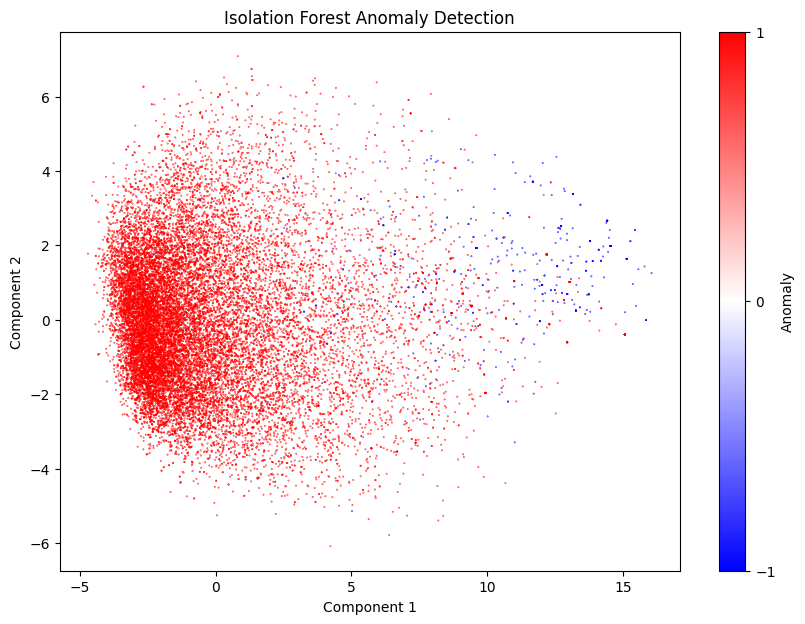

In [138]:
plt.figure(figsize=(10, 7))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df[f'anomaly-{contamination}'], cmap='bwr', s=0.1)
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Anomaly', ticks=np.arange(df[f'anomaly-{contamination}'].min(), df['anomaly-0.05'].max() + 1))
plt.show()

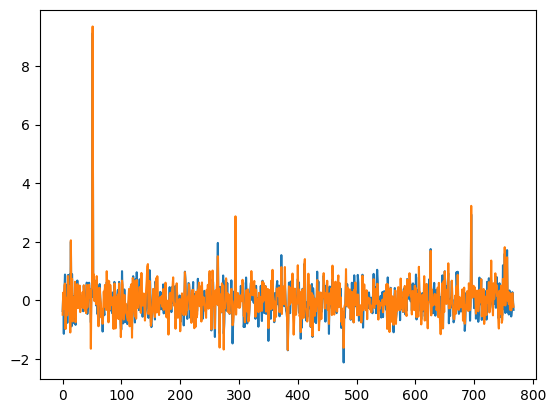

In [136]:
# texts = ["好吃", "好好吃", "很好吃", "好好吃哦", "超好吃", "超好吃的😋"]
texts = ["好好吃", "好好痴"]
t_texts = []
for text in texts:
    t_text = get_bert_embedding(text)
    t_texts.append(t_text)
    plt.plot(t_text)
plt.show()

In [131]:
sum(t_texts[0]-t_texts[1])

-1.3796813730150461

In [139]:
anomalies = df[df[f'anomaly-{contamination}'] == -1]

# 計算每個異常評論的出現次數
anomaly_counts = anomalies['comment'].value_counts()

# 按出現次數分組評論
grouped_comments = {}
for comment, count in anomaly_counts.items():
    if count not in grouped_comments:
        grouped_comments[count] = []
    grouped_comments[count].append(comment)

# 打印結果
for count, comments in sorted(grouped_comments.items())[::-1]:
    print(f"Count {count} : {comments}")

Count 25 : ['讚']
Count 12 : ['很棒', '👍 …']
Count 9 : ['好的']
Count 8 : ['不錯']
Count 7 : ['👍🏻 …', '不錯吃', '很讚']
Count 6 : ['還不錯']
Count 5 : ['超讚']
Count 4 : ['普通', '👍👍👍 …', '超棒', '好ㄘ', '很香']
Count 3 : ['還行', '美味', '喜歡', '溫馨', '讚讚讚', '推', '普普通通']
Count 2 : ['讚喔', '棒！', '悠閒享受', '特別', '老牌名店 ！', '羊羹', '還可', '🆗 …', '真材實料', '好香', '絕了', '齁甲', '👍', '五星吹捧推推', '普普', '明净雅间，白絜局佈。', '稱讚', '物美價廉，物超所值', '好地方', '美美躂^^', '👌🏽(●°u°●)👍🏾', '小雅局格，静淑逸然。', '都好好吃(˶‾᷄ ⁻̫ ‾᷅˵)', '底粒穴斯～', '😊 …', '這是一種美', '優秀', '讚讚👍 …', '差強人意', '。。。', '好', '非常的蛋', '口袋名單！！！', '推推', '🤤💗', '態度欠佳', '🐟', '問😄', '很好', '便宜', '讚讚', '鯛魚燒(˶‾᷄ ⁻̫ ‾᷅˵)', '網美店', '讚👍 …', '口袋名單']
Count 1 : ['悠閒', '很喜歡', '各方面都不錯', '包裝精緻', '產品介紹詳細', '大推', '路過試看看', '給五顆讚', '小而美😋😋 …', '豪ㄘ', '哈囉', '好吃!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '嚐鮮。', '服務佳', '普通👌 …', '內軟', '2F 咖啡👍👍👍👍👍👍👍👍 …', '口味佳', '太頂啦', '太多了', '經濟實惠', '大推番薯糖', '蕃薯很Q', '人多', '必吃', '咖啡 正', '蠻特別', '很chill~', '香蕉磅蛋糕推推！！', '好讚', '熱情', '❤️❤️❤️', '乾淨', '提拉米蘇', '狗勾', '便利', 'oec好呷', '75分', '很不錯', '佛心公司', '水果雙醬優格', '😍😋 …

In [76]:
# 將DataFrame存儲為JSON文件
# df.to_json('clustered_reviews.json', orient='records', force_ascii=False)